In [1]:
%run common.ipynb

['LC_Type1', 'LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LST_Day_1km', 'pr', 'aet', 'NDVI', 'EVI']
['LC_Type1']


In [2]:
%run tuning_common.ipynb

Using TensorFlow backend


In [3]:
MODEL_SAVE_DIR = f'{MODEL_FOLDER}downstream-randomforest/model/'

In [4]:
downstream_train_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TRAIN_FILENAME}.csv')
downstream_test_df = pd.read_csv(f'{DATA_FOLDER}{DOWNSTREAM_TEST_FILENAME}.csv')

In [5]:
downstream_train_df[CATEGORICAL_FEATURES] = downstream_train_df[CATEGORICAL_FEATURES].astype("category")
downstream_test_df[CATEGORICAL_FEATURES] = downstream_test_df[CATEGORICAL_FEATURES].astype("category")

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [7]:
import time
from sklearn.model_selection import RandomizedSearchCV

# n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None

param_dist = {
    'n_estimators':[500, 1000],
    'max_depth': [2,3,4,6,8,10],
    'max_features':[1.0, 3.0],
}

model = RandomForestRegressor(verbose=1, min_samples_leaf=2)

n_iter_search = 100
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=5)
start = time.time()
random_search.fit(downstream_train_df[FEATURES], downstream_train_df[TARGET_FEATURE])
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

/home/zheng.yant/.conda/envs/newTF_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Par

RandomizedSearchCV took 85.32 seconds for 100 candidates parameter settings.


[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s


In [10]:
import pickle

best_regressor = random_search.best_estimator_
with open(f"{MODEL_SAVE_DIR}model.pkl",'wb') as f:
    pickle.dump(best_regressor,f)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


RMSE prediction: 4415.3218
RMSE MOD17: 4560.9156
R-Squared prediction: 0.5316889407742236
R-Squared MOD17: 0.5002949217269026
Max error prediction: 11570.285593218081
Max error MOD17: 15912.398000000001
Mean poisson deviance prediction: 1712.3950934629725
Mean poisson deviance MOD17: 1803.3977004575927
Mean gamma deviance prediction: 0.20928264390293613
Mean gamma deviance MOD17: 0.23894647229563704
Mean pinball loss with alpha = 0.9 prediction: 1632.994132186092
Mean pinball loss with alpha = 0.9 MOD17: 2447.750632300064
Mean pinball loss with alpha = 0.09999999999999998 prediction: 1721.7159783451195
Mean pinball loss with alpha = 0.09999999999999998 MOD17: 958.2671090942837


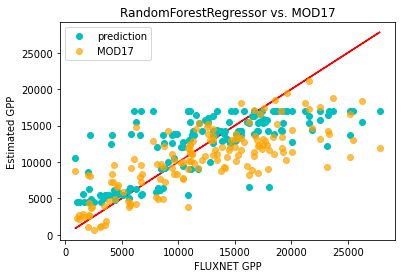

In [7]:
import pickle
from sklearn.metrics import mean_squared_error

with open(f"{MODEL_SAVE_DIR}model.pkl", 'rb') as f:
    best_regressor = pickle.load(f)
y_pred = best_regressor.predict(downstream_test_df[FEATURES])
modis_compare_data = get_modis_compare_data(y_pred)
get_all_metrics(y_pred, modis_compare_data[TARGET_FEATURE], downstream_test_df[TARGET_FEATURE])
plot_result_distribution(downstream_test_df[TARGET_FEATURE], y_pred, modis_compare_data[TARGET_FEATURE], save_dir=f'{MODEL_RESULT_PLT_DIR}RandomForest.png', title='RandomForestRegressor vs. MOD17')